<a href="https://colab.research.google.com/github/robotstech/similarity-ml/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### import all dependencies

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer

from matplotlib import pyplot as plt

from collections import Counter

### Constants

In [17]:
EPOCHS = 32
BATCH_SIZE = 32
NUM_TRAIN_IMAGES = 1000
IMAGE_SHAPE = (75, 75)

NUM_TEST_IMAGES = max(BATCH_SIZE, NUM_TRAIN_IMAGES * .25)

# Load data

### load the dataset (MNIST)

In [18]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


x_train = np.expand_dims(x_train, axis=-1) / 255.
x_test = np.expand_dims(x_test, axis=-1) / 255.

In [19]:
x_train.shape

(60000, 28, 28, 1)

# Visualize Data

### Label distribution

In [20]:
label_distribution = Counter(y_train)

label_distribution

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

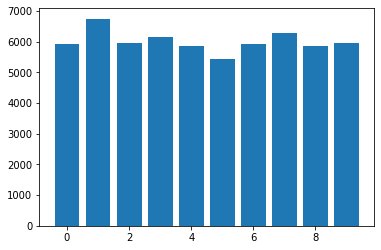

In [21]:
plt.bar(label_distribution.keys(), label_distribution.values())
plt.show()

### Data preview

the label is 7


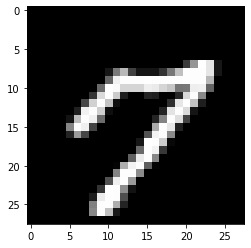

In [22]:
index = np.random.randint(x_train.shape[0])

print(f"the label is {y_train[index]}")
plt.imshow(x_train[index].reshape(28, 28), cmap="gray")
plt.show()

# Prepare Input

### Create triplet pair

In [23]:
def pad_image_pair_data(image_data, expected_output_shape):
    *_, old_height, old_width, _ = image_data.shape
    expected_height, expected_width = expected_output_shape

    height_pad1 = (expected_height - old_height) // 2
    height_pad2 = expected_height - old_height - height_pad1

    width_pad1 = (expected_width - old_width) // 2
    width_pad2 = expected_width - old_width - width_pad1

    new_image_data = np.pad(image_data, ((0, 0), (0, 0), (height_pad1, height_pad2), (width_pad1, width_pad2), (0, 0)))
    new_image_data = np.pad(new_image_data, ((0, 0), (0, 0), (0, 0), (0, 0), (1, 1)), 'maximum')
    return new_image_data

def generate_triplet_pairs(input_data: np.ndarray, output_data: np.ndarray, num_of_samples: int, expected_output_shape: tuple):    
    while True:
        # unique labels
        unique_labels = np.unique(output_data)
        
        # the batch data
        data_pairs = np.zeros((3, num_of_samples, *input_data.shape[1:]))
        label_pairs = np.zeros((3, num_of_samples), dtype=int)
        
        # the label count in batch
        label_sample_distr = Counter(np.random.choice(unique_labels, size=num_of_samples))
        
        # tracking the location in data pairs
        start = stop = 0
        
        for label, num_of_samples_per_label in label_sample_distr.items():

            similar_indices = np.where(output_data == label)[0]  
            dissimilar_indices = np.where(output_data != label)[0]

            anchor_values, positive_values = np.random.choice(
                similar_indices, size=(num_of_samples_per_label, 2), replace=False
            ).T
            negative_values = np.random.choice(dissimilar_indices, size=(num_of_samples_per_label,))

            # end track
            stop += negative_values.shape[0]

            data_pairs[0, start:stop] = input_data[anchor_values]
            data_pairs[1, start:stop] = input_data[positive_values]
            data_pairs[2, start:stop] = input_data[negative_values]

            label_pairs[0, start:stop] = anchor_values
            label_pairs[1, start:stop] = positive_values
            label_pairs[2, start:stop] = negative_values

            start = stop
        
        data_pairs = pad_image_pair_data(data_pairs, expected_output_shape)
        yield ([data_pairs[0], data_pairs[1], data_pairs[2]], label_pairs)

In [24]:
sample_pairs, sample_pairs_index = next(iter(generate_triplet_pairs(x_train, y_train, 4, IMAGE_SHAPE)))

print(f"sample_pairs shape = 3 x {sample_pairs[0].shape}\n")

# indices = np.random.choice(range(sample_pairs.shape[0]), size=10, replace=False)
for anchor_index, positive_index, negative_index in sample_pairs_index.T:
    print(f"a = {anchor_index:5d}:{y_train[anchor_index]:2d}"
          f", p = {positive_index:5d}:{y_train[positive_index]:2d}"
          f", n = {negative_index:5d}:{y_train[negative_index]:2d}"
         )

sample_pairs shape = 3 x (4, 75, 75, 3)

a = 32740: 7, p = 28362: 7, n = 50846: 4
a = 27037: 9, p = 21592: 9, n = 54205: 6
a = 25046: 9, p =  5592: 9, n = 43186: 0
a = 25580: 5, p = 48049: 5, n =  6268: 4


### Preview Pairs

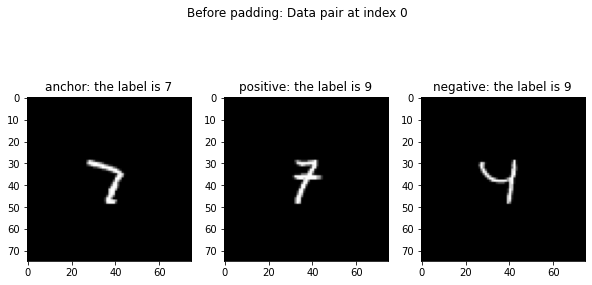

In [25]:
index = np.random.randint(sample_pairs[0].shape[0])

plt.figure(figsize=(10, 5))
plt.suptitle(f'Before padding: Data pair at index {index}')

plt.subplot(131)
plt.title(f"anchor: the label is {y_train[sample_pairs_index[index, 0]]}")
plt.imshow(sample_pairs[0][index, :, :, 0], cmap="gray")

plt.subplot(132)
plt.title(f"positive: the label is {y_train[sample_pairs_index[index, 1]]}")
plt.imshow(sample_pairs[1][index, :, :, 0], cmap="gray")

plt.subplot(133)
plt.title(f"negative: the label is {y_train[sample_pairs_index[index, 2]]}")
plt.imshow(sample_pairs[2][index, :, :, 0], cmap="gray")

plt.show()

### Rescale the image with padding for inception input

# Design Network

### create a basenetwork

In [26]:
def create_base_network_inception(input_shape):
    inp = (keras.Input(shape=input_shape))
    x = tf.keras.applications.InceptionV3(
        include_top=False,
        weights=None,
        input_tensor=None,
        input_shape=input_shape,
        pooling="max",
        classes=128,
        classifier_activation="relu",
    )(inp)
    
    out = layers.Dense(128)(x)
    
    # Model that can be trained with anchor, positive negative images
    model = Model(inp, out)
    return model

def create_base_network_custom(input_shape):
    return keras.Sequential(
        [
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D(pool_size=(2, 2)),
#             layers.Dropout(0.1),
            
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
#             layers.Dropout(0.1),
            
            
            layers.Flatten(),
            
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.1),
            
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.1),
            
            layers.Dense(128, activation="relu")
        ]
    )

create_base_network = create_base_network_inception

### Create triplet loss layer

In [27]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = super(TripletLossLayer, self).get_config()
        config.update({"alpha": self.alpha})
        return config

# Create network

### Initialize basenetwork

In [28]:
# Input for anchor, positive and negative images
input_shape = tuple(sample_pairs[0].shape[1:])

base_network = create_base_network(input_shape)

### the inception model summary

In [29]:
base_network.layers[1].summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [30]:
base_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
Total params: 22,065,056
Trainable params: 22,030,624
Non-trainable params: 34,432
_________________________________________________________________


### Construct Triplet network

In [31]:
anchor_input = keras.Input(shape=input_shape)
positive_input = keras.Input(shape=input_shape)
negative_input = keras.Input(shape=input_shape)

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = base_network(anchor_input)
emb_p = base_network(positive_input)
emb_n = base_network(negative_input)

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.1, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
triplet_network = Model([anchor_input, positive_input, negative_input], triplet_loss_layer)

## Visualize network

In [32]:
triplet_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128)          22065056    ['input_4[0][0]',                
                                                                  'input_5[0][0]',          

### Graphviz network

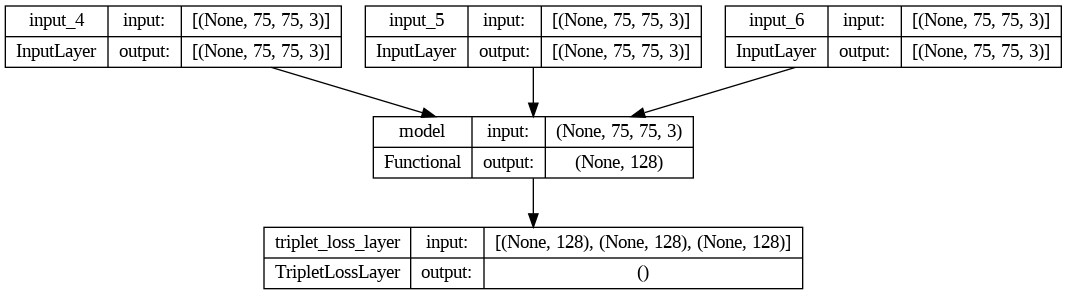

In [33]:
import tensorflow as tf

tf.keras.utils.plot_model(triplet_network, show_shapes=True, to_file="triplet_network.png")

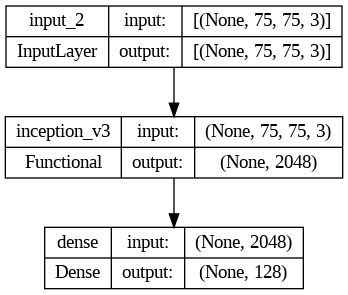

In [34]:
tf.keras.utils.plot_model(base_network, show_shapes=True, to_file="base_network.png")

# Run Model

### Compile model

In [35]:
triplet_network.compile(loss=None, optimizer='adam')

In [ ]:
early_stop_callback = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

train_generator = generate_triplet_pairs(x_train, y_train, BATCH_SIZE, IMAGE_SHAPE)
test_generator = generate_triplet_pairs(x_test, y_test, BATCH_SIZE, IMAGE_SHAPE)

history = triplet_network.fit(
    train_generator,
    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE,

    validation_data=test_generator,
    validation_steps=NUM_TEST_IMAGES // BATCH_SIZE,
    
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    
    callbacks=[early_stop_callback,]
)

Epoch 1/32
25/31 [=======================>......] - ETA: 1s - loss: 647.6017

### Visualize loss

In [ ]:
print(history.history.keys())

import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Determine threshold

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(data, embeddings, idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(data[idx1], cmap="gray")
    plt.subplot(122)
    plt.imshow(data[idx2], cmap="gray");
    
def pad_image_data(image_data):
    new_image_data = np.pad(image_data, ((0, 0), (34, 34), (34, 34), (0, 0)))
    new_image_data = np.pad(new_image_data, ((0, 0), (0, 0), (0, 0), (1, 1)), 'maximum')
    return new_image_data

### Sample a fraction of the dataset

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

num = x_train.shape[0]
num = range(num)
num = np.random.choice(num, size = 100, replace=False)

samples = pad_image_data(x_train[num])
sample_labels = y_train[num]

similarity_model = triplet_network.layers[3]
embedded = similarity_model.predict(samples)

### Show pair

In [ ]:
idx1, idx2 = 0, 1
show_pair(samples, embedded, idx1, idx2)

In [ ]:
from sklearn.decomposition import PCA

# display a 2D plot of the digit classes in the latent space
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Embeddings')
fig.set_figwidth(15)
fig.set_figheight(5)

pca1 = PCA(n_components=2)
z = pca1.fit_transform(samples.reshape(-1, samples.shape[1] * samples.shape[2] * samples.shape[3]))

ax1.scatter(z[:, 0], z[:, 1], c=sample_labels)
ax1.set_title("Raw Data")
ax1.set_xlabel("y")
ax1.set_ylabel("x")

pca2 = PCA(n_components=2)
z = pca2.fit_transform(similarity_model.predict(samples))

ax2.set_title("Data Embedding")
ax2.scatter(z[:, 0], z[:, 1], c=sample_labels)
ax2.set_xlabel("x")

plt.show()

In [ ]:
distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

for i, ii in enumerate(num):
    for j, jj in enumerate(num):
        if ii == jj:
            continue
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if y_train[ii] == y_train[jj] else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(distances.min(), distances.max(), distances.std())

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)

# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
opt_f1 = f1_scores[opt_idx]

# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'threshold {opt_tau:.2f}: acc = {opt_acc:.3f}, f1 = {opt_f1:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

In [ ]:
similarity_model.save("train_inception_mnist.h5")

In [ ]:
from tensorflow.keras.models import load_model

sm = load_model("train_inception_mnist.h5", compile=True, custom_objects={'TripletLossLayer': TripletLossLayer})

# References

1. Tess Ferrandez [research-papers repo](https://github.com/TessFerrandez/research-papers/blob/prod/facenet/FaceNet.ipynb)

# ==================End of Notebook==========================